# Earthquake Detection Using Seisbench 

In recent years, seismology has significantly benefited from machine learning (ML), which enhances efficiency, accuracy, and scope in earthquake detection. ML automates vast data processing, reducing manual effort and enabling real-time monitoring. It improves detection accuracy by recognizing patterns and anomalies often missed by traditional methods. ML models are adaptable and scalable, suitable for various regions and capable of analyzing global seismic data simultaneously. This notebook demonstrates the integration of Seisbench a common package used for ML studies, into an earthquake detection workflow.

- [Seisbench Documentation](https://github.com/seisbench/seisbench)
- [PhaseNet Documentation](https://github.com/AI4EPS/PhaseNet)
- [PyOcto Documentation](https://github.com/yetinam/pyocto)

This notebook also leverages **parallel processing**, a method that allows multiple computations to be carried out simultaneously, significantly speeding up data analysis by utilizing multiple CPU cores concurrently.

**Author:** Marc Garcia, University of Texas - El Paso, magarcia58@miners.utep.edu

In [1]:
#Check for correct Image (GeoLab)
!printenv | grep IMAGE


JUPYTER_IMAGE=public.ecr.aws/earthscope-dev/geolab_default:extensions-c1c714c1
DASK_GATEWAY__CLUSTER__OPTIONS__IMAGE={JUPYTER_IMAGE_SPEC}
JUPYTER_IMAGE_SPEC=public.ecr.aws/earthscope-dev/geolab_default:extensions-c1c714c1


In [3]:
# install necessary packages for notebook if needed
# !pip install seisbench 
# !pip install pyocto

# 1. Select Region of Interest(Cascadia Subduction Zone)

The Cascadia Subduction Zone is a major fault line stretching from northern California to British Columbia, where the Juan de Fuca Plate is subducting beneath the North American Plate. This region is known for producing significant seismic activity, including potential megathrust earthquakes.

For this study, we chose the UW (University of Washington) seismic network, which is ideal for testing and demonstrating our machine learning-based earthquake detection workflow. This demo is centered around the recent **magnitude 6.4 earthquake that occurred on July 11, 2024**, approximately 120 miles off Vancouver Island. This earthquake, the largest in a recent series of quakes, highlights the active seismic nature of the Cascadia region.

We start by developing a station list by pulling in stations within the defined geographic bounds of the Cascadia Subduction Zone using the ObsPy library. The following code snippet defines the client and geographic bounds, sets the time range for active channels in 2024, and fetches station metadata for the PNSN network (UW) with the desired channels.

In [4]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Define the client and geographic bounds of the Cascadia Subduction Zone
client = Client("IRIS")
min_latitude = 40.0
max_latitude = 50.0
min_longitude = -125.0
max_longitude = -120.0

# Define the time range for active channels in 2024
starttime = UTCDateTime('2024-01-01')
endtime = UTCDateTime('2024-12-31')

# Fetch station metadata within the defined region for the PNSN network UW, with desired channels
inv = client.get_stations(network="UW", station="*", location="*", channel="HH*", 
                                minlatitude=min_latitude, maxlatitude=max_latitude,
                                minlongitude=min_longitude, maxlongitude=max_longitude,
                                starttime=starttime, endtime=endtime, level="response")

print(inv)

Inventory created at 2025-05-12T14:04:16.981300Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2024-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			UW
		Stations (143):
			UW.ABER (Abernathy Mountain, Cowlitz County, WA, USA)
			UW.ANGUS (Elk Ridge Ranch, WA, USA)
			UW.ARTIC (Weyerhaeuser Tree Farm, Grays Harbor County, WA, USA)
			UW.ASR2 (Mt. Adams - Stagman Ridge, WA, USA)
			UW.BABR (Baber Butte, OR, USA)
			UW.BBO (Butler Butte, OR, USA)
			UW.BDGR (Fisse-Smith Property, Kittitas, WA, USA)
			UW.BHAM (Bellingham, WA, USA)
			UW.BHW (Bald Hill, WA, USA)
			UW.BICK (Bickleton Ranch,Bickleton, WA, USA)
			UW.BLOB (Calvert Residence, Oakville, WA, USA)
			UW.BLOW (Detroit Lake, OR, USA)
			UW.BOIS (Boistfort Consolidated School, Curtis, WA, USA)
			UW.BRO (Big Rock Lookout, OR, USA)
			UW.BST09 (BEST site 09, Seattle, WA, USA)
			UW.BUCKS (Joyce, WA, USA)
			UW.CBS (Chelan 

## Visualizing the stations within the region to understand their distribution and coverage

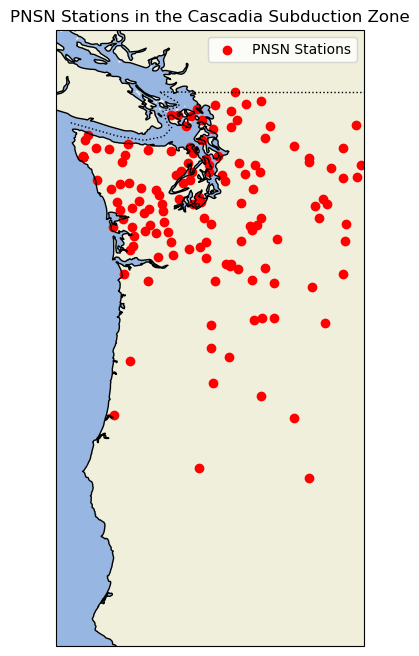

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract station coordinates
stations = [(station.latitude, station.longitude) for network in inv for station in network.stations]

# Create a plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add geographic features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the map bounds
ax.set_extent([min_longitude, max_longitude, min_latitude, max_latitude], crs=ccrs.PlateCarree())

# Plot the stations
if stations:
    lats, lons = zip(*stations)
    ax.scatter(lons, lats, color='red', marker='o', transform=ccrs.PlateCarree(), label='PNSN Stations')

# Add labels and title
ax.set_title('PNSN Stations in the Cascadia Subduction Zone')
ax.legend()

# Show the plot
plt.show()

# 2. Phase Picking with PhaseNet (Seisbench) 


Using **PhaseNet** with **Seisbench** for phase picking significantly enhances earthquake detection by leveraging machine learning for precise seismic data analysis. PhaseNet, a pre-trained model available in Seisbench, automates the classification of seismic phases (P and S waves), which is crucial for accurate earthquake detection and analysis. The code demonstrates a workflow for using PhaseNet to classify seismic phases within a specified time window, utilizing parallel processing to handle large datasets efficiently.

The code begins by setting up necessary imports and initializing the PhaseNet model. It defines a period of interest and extracts a list of stations from the inventory. A function **fetch_waveform_data** is created to fetch waveform data for a given station within a specified time window. The central processing loop iterates through each time window, fetching and combining waveform data from multiple stations concurrently using ThreadPoolExecutor. This parallel processing approach significantly speeds up data retrieval, using multiple CPU cores to handle the high volume of seismic data.

Once the waveform data is retrieved, PhaseNet classifies the data to identify P and S wave picks. These picks are then added to a catalog, which is later fed into the associator for further analysis. 

> NOTE: This process can take up to 10 minutes or more to identify P and S wave picks for each waveform and may take serveral hours to complete using this data.

In [ ]:
from obspy import UTCDateTime, Stream
import pandas as pd
from collections import Counter
import seisbench.models as sbm
import time, random
from concurrent.futures import ThreadPoolExecutor, as_completed

picker = sbm.PhaseNet.from_pretrained("original")

# Initialize a single catalog for picks
pick_list = []

# Define start and end times for the period of interest
start_time = UTCDateTime("2024-07-11T00:00:00")
end_time = UTCDateTime("2024-07-13T00:00:00")
window_time = 7200  # Customize windows for fetching data

# Extract stations from the inventory
station_list = [{
    'Network': network.code,
    'Station': station.code
} for network in inv for station in network.stations]


# Function to fetch and filter waveform data for a given station
def fetch_waveform_data(station, current_time, window_time):
    try:
        stream = client.get_waveforms(
            network=station['Network'],
            station=station['Station'],
            location="*",
            channel="HH?",
            starttime=current_time,
            endtime=current_time + window_time
        )
        if stream:
            stream.detrend()  # Detrend before filtering
            stream.filter("highpass", freq=5)  # Apply highpass filter at 5 Hz
        return stream
    except Exception:
        return Stream()

# Loop through each time window
current_time = start_time

while current_time < end_time:
    combined_stream = Stream()
    
    # Measure the time taken to download data
    start_download_time = time.time()
    with ThreadPoolExecutor(max_workers=32) as executor:
        futures = [executor.submit(fetch_waveform_data, station, current_time, window_time) for station in station_list]
        for future in as_completed(futures):
            combined_stream += future.result()
    end_download_time = time.time()
    
    # Classify the combined stream using the PhaseNet picker if it is not empty
    if combined_stream:
        try:
            start_processing_time = time.time()
            picks = picker.classify(
                combined_stream, 
                batch_size=256, 
                P_threshold=0.075, 
                S_threshold=0.1
            ).picks
            end_processing_time = time.time()
            
            # Append picks to the catalog
            pick_list.extend([{
                "id": p.trace_id,
                "timestamp": p.peak_time.datetime,
                "prob": p.peak_value,
                "type": p.phase.lower()
            } for p in picks])
            
            # Print the count of P and S picks and the processing time
            pick_count = Counter(p.phase for p in picks)
            download_time = end_download_time - start_download_time
            processing_time = end_processing_time - start_processing_time
            print(f"Time window starting at {current_time}: {pick_count} (Download time: {download_time:.2f} seconds, Processing time: {processing_time:.2f} seconds)")
        
        except Exception as e:
            print(f"Error processing combined stream at {current_time}: {e}")
    
    # Move to the next time window
    current_time += window_time

# Convert the pick catalog to a DataFrame for further analysis or export
pick_df = pd.DataFrame(pick_list)

# Print the total number of picks
print(f"Total number of picks: {len(pick_df)}")

/srv/conda/envs/notebook/lib/python3.12/site-packages/seisbench/models/base.py:489: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(f"{path_pt}")


Time window starting at 2024-07-11T00:00:00.000000Z: Counter({'P': 4152, 'S': 2960}) (Download time: 26.43 seconds, Processing time: 620.73 seconds)
Time window starting at 2024-07-11T02:00:00.000000Z: Counter({'P': 3881, 'S': 2757}) (Download time: 35.15 seconds, Processing time: 621.87 seconds)
Time window starting at 2024-07-11T04:00:00.000000Z: Counter({'P': 3549, 'S': 2592}) (Download time: 25.85 seconds, Processing time: 617.83 seconds)
Time window starting at 2024-07-11T06:00:00.000000Z: Counter({'P': 2719, 'S': 1987}) (Download time: 21.62 seconds, Processing time: 618.56 seconds)
Time window starting at 2024-07-11T08:00:00.000000Z: Counter({'P': 3044, 'S': 2234}) (Download time: 32.73 seconds, Processing time: 611.89 seconds)
Time window starting at 2024-07-11T10:00:00.000000Z: Counter({'P': 4168, 'S': 3173}) (Download time: 22.75 seconds, Processing time: 607.68 seconds)
Time window starting at 2024-07-11T12:00:00.000000Z: Counter({'P': 4601, 'S': 3482}) (Download time: 33.93

# 3. Phase Association with PyOcto

PyOcto is a high-throughput seismic phase associator that efficiently links seismic phases to specific earthquake events, accurately determining their locations and origin times. It utilizes a 4D space-time partitioning method, starting with a large node that spans the entire study area and iteratively refines potential earthquake locations by splitting nodes based on the highest number of picks. This process is managed using a priority queue system, enhancing processing speed by discarding non-promising nodes early. PyOcto supports homogeneous and 1D velocity models and allows for customizable parameters for multi-region studies. 

**Note: PyOcto outputs locations, but these are meant to be initial sources. Further refinement of locations is needed for accurate locations.** 

### Associator Configurations

In [ ]:
import pyocto

# Define the velocity model with specified parameters
velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
    association_cutoff_distance=300,
)

# Create the associator with corrected latitude and longitude ranges
associator = pyocto.OctoAssociator.from_area(
    lat=(40, 55),  
    lon=(-135, -120),  
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=6,
    n_p_and_s_picks=3,
)

# Convert station information to the required format
stations = associator.inventory_to_df(inv)


In [ ]:
# stations_df = stations
# stations_df.head()
print(stations)

### Association

In [ ]:
# Perform the phase association 
events, assignments = associator.associate_seisbench(picks, stations)

# Transform event coordinates back to latitude and longitude
associator.transform_events(events)

# 4. Visualize the Results 

## Map View of Located Events

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

min_latitude = 41.0
max_latitude = 54.0
min_longitude = -132.0
max_longitude = -118.0

# Extract station coordinates
stations = [(station.latitude, station.longitude) for network in inv for station in network.stations]

# Extract event coordinates
event_lats = events['latitude'].tolist()
event_lons = events['longitude'].tolist()

# Create a plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add geographic features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the map bounds
ax.set_extent([min_longitude, max_longitude, min_latitude, max_latitude], crs=ccrs.PlateCarree())

# Plot the stations
if stations:
    lats, lons = zip(*stations)
    ax.scatter(lons, lats, color='red', marker='o',s=10, transform=ccrs.PlateCarree(), label='PNSN Stations')

# Plot the earthquake events
ax.scatter(event_lons, event_lats, color='blue', marker='x',s=12, transform=ccrs.PlateCarree(), label='Earthquake Events')

# Add labels and title
ax.set_title('Earthquake Events in the Cascadia Subduction Zone')
ax.legend()

# Show the plot
plt.show()